In [ ]:
!nvidia-smi

Wed Jul 19 23:52:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%pip install -q \
    flax \
    optax==0.1.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.3/360.3 kB 4.5 MB/s eta 0:00:00


In [1]:
from dataclasses import dataclass
from functools import partial
import hashlib
import io
import json
import os
import pickle
import sys
from typing import Any
import time

import flax.linen as nn
from IPython import display
import jax
from jax import jit, lax, vmap, grad
import jax.numpy as jnp
from jax import random
from jax.scipy.signal import correlate2d, convolve2d
import matplotlib.pyplot as plt
import numpy as np
import optax
import PIL.Image as Image
import requests
is_cpu = jax.default_backend() == 'cpu'

In [2]:
def weight_count(tree):
    shapes = jax.tree_util.tree_map(lambda a: np.product(a.shape), tree)
    return np.sum(jax.tree_util.tree_leaves(shapes))

## NCA Model

In [3]:
@jit
def convolve_state_grid(state_grid, filter):
    def _convolve_channel_grid(channel_grid):
        return correlate2d(channel_grid, filter, mode='same')
    return vmap(_convolve_channel_grid, in_axes=-1, out_axes=-1)(state_grid)


@jit
def perceive(state_grid):
    sobel_x = jnp.array([
        [-1, 0, +1],
        [-2, 0, +2],
        [-1, 0, +1]
    ])
    sobel_y = sobel_x.T
    dx = convolve_state_grid(state_grid, sobel_x)
    dy = convolve_state_grid(state_grid, sobel_y)
    perception_grid = jnp.concatenate([state_grid, dx, dy], axis=-1)
    return perception_grid

@jit
def stochastic_update(rng, update_grid, update_pct):
    update_mask = random.uniform(rng, update_grid.shape[:-1])
    update_mask = update_mask < update_pct
    update_mask = jnp.expand_dims(update_mask, -1)
    update_grid *= update_mask
    return update_grid

@jit
def alive_mask(state_grid, alive_threshold):
    alive_grid = state_grid[:, :, 0:1]
    alive_grid = nn.max_pool(alive_grid, window_shape=(3, 3), strides=(1,1), padding='SAME')
    alive_grid = alive_grid > alive_threshold
    return alive_grid

class NCA(nn.Module):
    mlp_hidden: int
    channels: int
    update_pct: float
    alive_threshold: float

    @nn.compact
    def __call__(self, state_grid, rng=None):
        sequential = nn.Sequential([
            nn.Dense(features=self.mlp_hidden),
            nn.relu,
            nn.Dense(features=channels, kernel_init=nn.initializers.constant(0.))
        ])
        perception_grid = perceive(state_grid)
        update_grid = vmap(vmap(sequential))(perception_grid)
        if rng is not None:
            update_grid = stochastic_update(rng, update_grid, self.update_pct)
        alive_grid = alive_mask(state_grid, self.alive_threshold)
        state_grid += update_grid
        state_grid *= alive_grid
        return state_grid

In [4]:
@dataclass
class Grid:
    grid_shape: int
    channels: int
    
    def init(self):
        width, height = self.grid_shape
        x = jnp.zeros(shape=(height, width, self.channels))
        x = x.at[height//2, width//2, :].set(1.)
        return x

In [5]:
@dataclass
class Pool:
    x: Any
    size: int
    reinit_size: int
    
    def init(self):
        return jnp.repeat(jnp.expand_dims(self.x, 0), self.size, axis=0)
    
    def sample(self, rng, pool_params, batch_size):
        sample_idx = random.choice(rng, pool_params.shape[0], (batch_size,), replace=False)
        batch = pool_params[sample_idx]
        return batch

    def update(self, rng, pool_params, pool_updates):
        idx = random.choice(rng, pool_params.shape[0], (pool_updates.shape[0],), replace=False)
        return pool_params.at[idx].set(pool_updates)

    def reinit(self, rng, pool_params):
        rng, r = random.split(rng)
        idx = random.choice(r, pool_params.shape[0], (self.reinit_size,), replace=False)
        pool_params = pool_params.at[idx].set(self.x)
        return pool_params

In [6]:
@dataclass
class Simulator:
    model: Any
    
    def simulate(self, rng, grid_params, model_params, simulation_steps, return_steps=False):
        def step(grid_params, rng):
            next_grid_params = self.model.apply(model_params, grid_params, rng)
            return next_grid_params, grid_params
        rngs = jnp.array(random.split(rng, simulation_steps))
        final_grid_params, grid_param_steps = lax.scan(step, grid_params, xs=rngs)
        if return_steps:
            return final_grid_params, grid_param_steps
        else:
            return final_grid_params

    def batch_simulate(self, rng, grid_params_batch, model_params, simulation_steps):
        batch_size = grid_params_batch.shape[0]
        rngs = jnp.array(random.split(rng, batch_size))
        def _simulate(r, grid_params):
            return self.simulate(
                rng=r,
                grid_params=grid_params,
                model_params=model_params,
                simulation_steps=simulation_steps)
        return vmap(_simulate)(rngs, grid_params_batch)
    

In [7]:
@jit
def image_loss(state_grid, target_image):
    y = target_image
    yp = state_grid[..., 0]
    return jnp.mean(optax.l2_loss(y, yp))

@jit
def normalize(a, eps=1e-9):
    norm = jnp.linalg.norm(a)
    return a / (norm + eps)


@dataclass
class Trainer:
    pool: Pool
    simulator: Simulator
    optimizer: Any
    target_image: Any
    simulation_steps: int
    
    @partial(grad, argnums=2, has_aux=True)
    def grads_and_updated_state_grid_batch(self, rng, model_params, grid_params_batch):
        print('compile')
        grid_params_batch = self.simulator.batch_simulate(
            rng=rng,
            grid_params_batch=grid_params_batch,
            model_params=model_params,
            simulation_steps=self.simulation_steps)
        def _loss(grid_params):
            return image_loss(grid_params, self.target_image)
        losses = vmap(_loss)(grid_params_batch)
        loss = jnp.mean(losses)
        return loss, (loss, grid_params_batch)
    
    
    def update(self, grads, model_params, optimizer_state):
        grads = jax.tree_map(normalize, grads)
        updates, optimizer_state = self.optimizer.update(grads, optimizer_state, model_params)
        model_params = optax.apply_updates(updates, model_params)
        return model_params, optimizer_state
    
    def step(self, rng, pool_params, model_params, optimizer_state):   
        rng, r = random.split(rng)
        grid_params_batch = self.pool.sample(r, pool_params, batch_size)
        rng, r = random.split(rng)
        grads, (loss, updated_state_grid_batch) = self.grads_and_updated_state_grid_batch(
            r,
            model_params,
            grid_params_batch)
        rng, r = random.split(rng)
        pool_params = self.pool.update(
            rng=r,
            pool_params=pool_params,
            pool_updates=updated_state_grid_batch,
        )
        rng, r = random.split(rng)
        pool_params = self.pool.reinit(r, pool_params)
        model_params, optimizer_state = self.update(
            grads=grads,
            model_params=model_params,
            optimizer_state=optimizer_state)
    
        return pool_params, model_params, optimizer_state, loss

## Training

In [8]:
@partial(jit, static_argnames=('scale'))
def zoom(img, scale=4):
    img = jnp.repeat(img, scale, 0)
    img = jnp.repeat(img, scale, 1)
    return img

def render_video(frames, frames_per_second, output_path):
    frame_count = frames.shape[0]
    frame_size = frames.shape[1]
    frame_shape = (frame_size,) * 2
    with FFMPEG_VideoWriter(size=frame_shape, fps=frames_per_second, filename=output_path) as writer:
        for fr in range(frame_count):
            frame = frames[fr]
            writer.write_frame(frame)

def download_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    response = requests.get(f'https://github.com/googlefonts/noto-emoji/blob/main/png/128/emoji_u{code}.png?raw=true')
    response.raise_for_status()
    img_bytes = response.content
    img = Image.open(io.BytesIO(img_bytes))
    img_array = np.array(img)
    return img_array

@jit
def premultiply_alpha(img):
    return img[..., :3] * jnp.expand_dims(img[..., 3], -1)

@jit
def to_rgb(state_grid):
    rgb = jnp.clip(state_grid, 0., 1.)
    rgb *= 255.
    rgb = jnp.uint8(rgb)
    return rgb

@jit
def grid_params_to_frame(grid_params, target_image):
    frame = grid_params[..., 0]
    frame = to_rgb(frame)
    frame = jnp.expand_dims(frame, -1)
    frame = jnp.repeat(frame, repeats=3, axis=-1)
    frame = frame.at[..., 1].set(to_rgb(target_image))
    frame = zoom(frame, scale=8)
    return frame
    
def display_simulation(out, grid_param_steps, target_image):
    for i in range(grid_param_steps.shape[0]):
        frame = grid_params_to_frame(grid_param_steps[i], target_image)
        frame = Image.fromarray(np.array(frame))
        out.update(frame)

In [9]:
grid_shape = (32, 32)
emoji = "♥"
emoji = download_emoji(emoji)
target_image = emoji[..., 3]
target_image = Image.fromarray(target_image)
target_image.thumbnail(grid_shape)
target_image = np.array(target_image)
target_image = np.float32(np.clip(0., 1., target_image/255))

In [10]:
rng = random.PRNGKey(42)
channels = 16
hidden_channels = 128
batch_size = 8
pool_size = 64
simulation_steps = 32
eval_simulation_steps = 128
pool_reinit_size = 1
nca = NCA(
    mlp_hidden=hidden_channels,
    channels=channels,
    update_pct=.5,
    alive_threshold=.1
)
learning_rate = 1e-3
grid = Grid(grid_shape=grid_shape, channels=channels)
grid_params = grid.init()
pool = Pool(x=grid_params, size=pool_size, reinit_size=pool_reinit_size)
rng, r = random.split(rng)
model_params = nca.init(r, grid_params)
optimizer = optax.adam(learning_rate=learning_rate)
optimizer_state = optimizer.init(model_params)
pool_params = pool.init()
simulator = Simulator(model=nca)
trainer = Trainer(pool=pool, simulator=simulator, simulation_steps=simulation_steps, optimizer=optimizer, target_image=target_image)
losses = []

@jit
def train_step(*args, **kwargs):
    return trainer.step(*args, **kwargs)

In [11]:
steps = range(1,4) if is_cpu else range(1, 10_000)
start = time.time()
for i in steps:
    if i % 500 == 0:
        rng, r = random.split(rng)
        final_grid_params = simulator.simulate(
            rng=r,
            grid_params=grid_params,
            model_params=model_params,
            simulation_steps=eval_simulation_steps)
        loss = image_loss(final_grid_params, target_image)
        print(i, loss, time.time() - start)
        start = time.time()

    rng, r = random.split(rng)
    pool_params, model_params, optimizer_state, loss = train_step(r, pool_params, model_params, optimizer_state)
    if len(steps) < 10:
        print(i, loss)
    losses.append(loss)

#assert loss == 0.26868594

compile
1 0.2829152
2 0.2764838
3 0.26868594


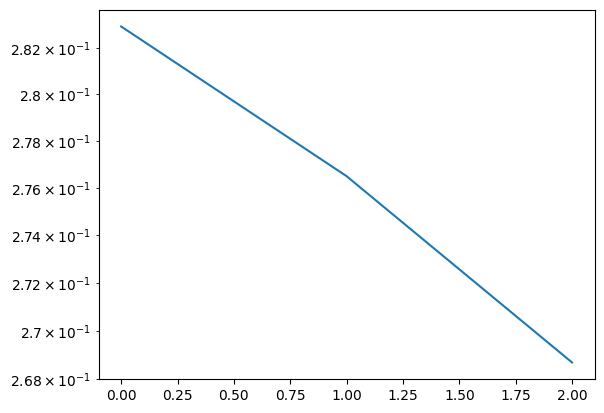

In [12]:
plt.yscale('log')
plt.plot(losses)

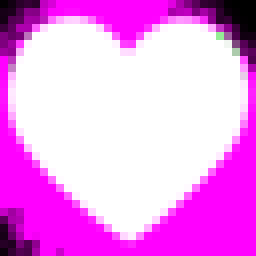

In [16]:
rng, r = random.split(rng)
_, grid_param_steps = simulator.simulate(
        rng=r,
        grid_params=grid_params,
        model_params=model_params,
        simulation_steps=eval_simulation_steps,
        return_steps=True)
out = display.display(None, display_id=True)
display_simulation(out, grid_param_steps, target_image)